# Homework - Neural networks - Part C (25 points)
## A neural network model of semantic cognition

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
This homework is due before midnight on Monday, Feb. 13, 2023.
</div>

In this assignment, you will help implement and analyze a neural network model of semantic cognition. Semantic cognition is our intuitive understanding of objects and their properties. Semantic knowledge includes observations of which objects have which properties, and storage of these facts in long term memory. It also includes the ability to generalize, or predict which properties apply to which objects although they have not been directly observed.

This notebook explores a neural network model of semantic cognition developed by Rogers and McClelland (R&M). R&M sought to model aspects of semantic cognition with a multi-layer neural network, which contrasts with classic symbolic approaches for organizing semantic knowledge. They model the cognitive development of semantic representation as gradient descent (the backpropgation algorithm), using a neural network trained to map objects to their corresponding properties. R&M also modeled the deterioration of semantic knowledge in dementia by adding noise to the learned representations.

The network architecture is illustrated below.
<img src="images/semcog_net.jpeg" style="width: 450px;"/>
There are two input layers ("Item Layer" and "Relation Layer"), which pass through intermediate layers to produce an output pattern on the "Attribute Layer." In this example, dark green is used to indicate active nodes (activation 1) and light green for inactive nodes (activation 0). The network is trained to answer queries involving an item (e.g., “Canary”) and a relation (e.g.,  “CAN”), outputting all attributes that are true of the item/relation pair (e.g., “grow, move, fly, sing”).

For this assignment, you will set up the network architecture in PyTorch and train it. The dataset and code for training has been provided. You will then analyze how its semantic knowledge develops of the course of training. While the original model used logistic (sigmoid) activation functions for all of the intermediate and output layers, we will use the ReLu activation for the Representation and Hidden Layers, with a sigmoid activation for the Attribute Layer.

Completing this assignment requires knowledge of setting up a neural network architecture in PyTorch. Please review your notes from lab and the following [PyTorch tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

<div class="alert alert-info">
Reference (available for download on Brightspace):
    
McClelland, J. L., & Rogers, T. T. (2003). The parallel distributed processing approach to semantic cognition. Nature Reviews Neuroscience, 4(4), 310.
</div>

In [2]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

Let's first load in the names of all the items, attributes, and relations into Python lists.

In [3]:
with open('data/sem_items.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])
        
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(names_items)
print("List of relations:")
print(names_relations)
print("List of attributes:")
print(names_attributes)

List of items:
['Pine' 'Oak' 'Rose' 'Daisy' 'Robin' 'Canary' 'Sunfish' 'Salmon']
List of relations:
['ISA' 'Is' 'Can' 'Has']
List of attributes:
['Living thing' 'Plant' 'Animal' 'Tree' 'Flower' 'Bird' 'Fish' 'Pine'
 'Oak' 'Rose' 'Daisy' 'Robin' 'Canary' 'Sunfish' 'Salmon' 'Pretty' 'Big'
 'Living' 'Green' 'Red' 'Yellow' 'Grow' 'Move' 'Swim' 'Fly' 'Sing' 'Skin'
 'Roots' 'Leaves' 'Bark' 'Branch' 'Petals' 'Wings' 'Feathers' 'Gills'
 'Scales']


Next, let's load in the data matrix from a text file too. The matrix `D` has a row for each training pattern. It is split into a matrix of input patterns `input_pats` (item and relation) and their corresponding output patterns `output_pats` (attributes). There are `N` patterns total in the set.

For each input pattern, the first 8 elements indicate which item is being presented, and the next 4 indicate which relation is being queried. Each element of the output pattern corresponds to a different attribute. All patterns use 1-hot encoding.

In [4]:
D = np.loadtxt('data/sem_data.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:8]])
print('Relation ',end='')
print(names_relations[input_v[8:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[1 0 0 0 0 0 0 0 1 0 0 0]
Example output pattern:
[1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['Pine']
Relation ['ISA']
Attributes ['Living thing' 'Plant' 'Tree' 'Pine']


<div class="alert alert-success" role="alert">
<h3> Problem 1 (20 points) </h3>
<br>
Your assignment is to create the neural network architecture shown in the figure above. Fill in the missing pieces of the "Net" class in the code below. For an example, refer to the PyTorch tutorial on <a href="https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py">"Neural Networks"</a>.
<br><br>
Use the ReLu activation function ("relu") for the Representation and Hidden Layers, with a Logistic/Sigmoid activation function for the Attribute Layer ("sigmoid").    
<br><br>
You will need PyTorch's "nn.Linear" function for constructing the layers, and the "relu" and "sigmoid" activation functions.
</div>

In [5]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_size : number of hidden units in "Hidden Layer"
        #
        self.rep_size = rep_size
        self.hidden_size = hidden_size
        # representation layer
        self.fc1 = nn.Linear(8, rep_size)
        # hidden layer
        self.fc2 = nn.Linear(rep_size+4, hidden_size)
        # output layer
        self.fc3= nn.Linear(hidden_size, 36)

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation Layer
        x = x.view(-1,nobj+nrel) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_pat_item = x[:,:nobj] # input to Item Layer [B x nobj Tensor]
        x_pat_rel = x[:,nobj:] # input to Relation Layer [B x nrel Tensor]
        #
        rep = relu(self.fc1(x_pat_item))
        hidden = relu(self.fc2(torch.cat((rep, x_pat_rel), dim=1)))
        output = sigmoid(self.fc3(hidden))
        # -----
        return output, hidden, rep

We provide a completed function `train` for stochastic gradient descent. The network makes online (rather than batch) updates, adjusting its weights after the presentation of each input pattern.

In [6]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
        for p in perm: # iterate through input patterns in random order
            mynet.zero_grad() # reset gradient
            output, hidden, rep = mynet(input_pats[p,:]) # forward pass
            target = output_pats[p,:] 
            loss = criterion(output, target) # compute loss
            loss.backward() # compute gradient 
            optimizer.step() # update network parameters
            error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        if e % 50 == 0:
            print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

We provide some useful functions for extracting the activation pattern on the Representation Layer for each possible item. We provide two functions `plot_rep` and `plot_dendo` for visualizing these activation patterns.

In [7]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(nobj,nobj+nrel)
    for idx,name in enumerate(names_items):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()

def plot_rep(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    nrows = nobj
    R = np.dstack((rep1,rep2,rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(7,12))
    plt.subplot(3,1,1)    
    dendrogram(linked1, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
    plt.ylabel('Euclidean distance')
    plt.subplot(3,1,2)
    plt.title("epoch " + str(nepochs_list[1]))
    dendrogram(linked2, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.show()

The next script initializes the neural network and trains it for 2500 epochs total. It trains in three stages, and the item representations (on the Representation Layer) are extracted after 500 epochs, 1000 epochs, and then at the end of training (2500 epochs).

In [8]:
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 500
nepochs_phase2 = 1000
nepochs_phase3 = 2500
epoch_count = 0
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase1)
rep1 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase2-nepochs_phase1)
rep2 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase3-nepochs_phase2)
rep3 = get_rep(mynet)


epoch 0 loss 0.243


C:\Users\HP\Anaconda3\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\HP\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([1, 36])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 50 loss 0.07
epoch 100 loss 0.066
epoch 150 loss 0.06
epoch 200 loss 0.054
epoch 250 loss 0.05
epoch 300 loss 0.047
epoch 350 loss 0.045
epoch 400 loss 0.043
epoch 450 loss 0.041
epoch 500 loss 0.039
epoch 550 loss 0.036
epoch 600 loss 0.032
epoch 650 loss 0.029
epoch 700 loss 0.026
epoch 750 loss 0.025
epoch 800 loss 0.023
epoch 850 loss 0.022
epoch 900 loss 0.02
epoch 950 loss 0.018
epoch 1000 loss 0.016
epoch 1050 loss 0.014
epoch 1100 loss 0.012
epoch 1150 loss 0.011
epoch 1200 loss 0.01
epoch 1250 loss 0.009
epoch 1300 loss 0.009
epoch 1350 loss 0.008
epoch 1400 loss 0.007
epoch 1450 loss 0.007
epoch 1500 loss 0.006
epoch 1550 loss 0.006
epoch 1600 loss 0.005
epoch 1650 loss 0.005
epoch 1700 loss 0.004
epoch 1750 loss 0.004
epoch 1800 loss 0.004
epoch 1850 loss 0.003
epoch 1900 loss 0.003
epoch 1950 loss 0.003
epoch 2000 loss 0.003
epoch 2050 loss 0.003
epoch 2100 loss 0.003
epoch 2150 loss 0.003
epoch 2200 loss 0.002
epoch 2250 loss 0.002
epoch 2300 loss 0.002
epoch 2350 lo

Finally, let's visualize the Representation Layer at the different stages of learning.

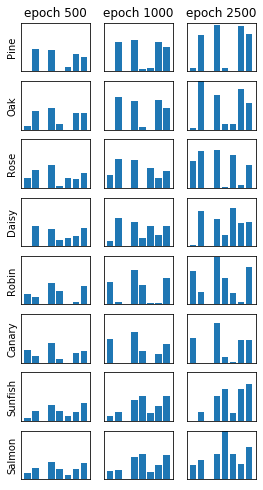

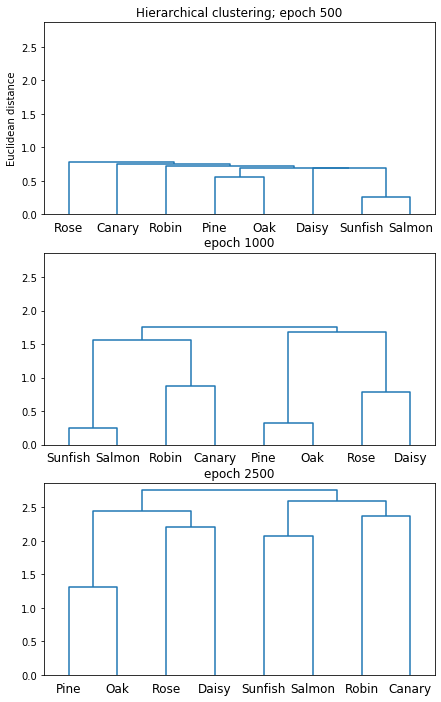

In [9]:
plot_rep(rep1,rep2,rep3,names_items)
plot_dendo(rep1,rep2,rep3,names_items)

<div class="alert alert-success" role="alert">
<h3> Problem 2 (5 points) </h3>
<br>
Based on your plots, write a short analysis (4-5 sentences) of how the internal representations of the network develop over the course of learning. How does learning progress? Does the network start by differentiating certain classes of patterns from each other, and then differentiate others in later stages?
</div>

<div class="alert alert-info">
Hint: You can refer to your lecture slides and notes for the R&M model for help with your analysis. Your network should broadly replicate their findings, but since the training patterns and activation function aren't identical, don't expect the exact same results.
</div>

It starts from differentiating animals and plants, then it gradually detect the differences between species. For instance, trees from flowers, and fish from birds.